In [ ]:
!pip install boto3 botocore pandas
!pip install openai
!pip install networkx
!pip install matplotlib
!pip install matplotlib.pyplot

In [2]:
import boto3
import pandas as pd
from io import BytesIO
from botocore import UNSIGNED
from botocore.config import Config
import os

#add_key_here
api_key=""

# Load the file content into a pandas DataFrame
df_sm = pd.read_csv('russia_social_media.csv')

print(df_sm.head())

                                     id                 time  \
0  0007ed21-eb78-597d-9558-9dfa4f75ed3e  2024-03-31 18:19:25   
1  0009a799-5b15-5468-98df-9e948518c786  2024-03-31 07:00:20   
2  000fea05-105e-589a-ad1e-9901e6594e86  2024-03-31 09:04:00   
3  0012d254-46b1-5d52-ad6e-b6a8bf7b8fc7  2024-03-31 06:22:18   
4  00194b54-be02-5a6d-a961-b9be56f22a54  2024-03-31 17:36:03   

                                                body  \
0  https://youtu.be/1H65fWYoaV8?si=sFwduH6AodNglB...   
1  🇷🇺🇺🇦Последствия обстрела жилых домой Белгорода...   
2  "ТАРЕЛОЧКИ" У НАС.\nДорогие подписчики! Делимс...   
3  На Камчатке в соединении кораблей охраны водно...   
4  Как устраняли предателя КузьминоваТрусливого п...   

                                         translation  \
0  https://youtu.be/1H65fWYoaV8?si=sFwduH6AodNglB...   
1  🇷🇺🇺🇦The consequences of shelling of residentia...   
2  WE HAVE "PLATES".\nDear subscribers! We share ...   
3  In Kamchatka, a formation of ships guarding th...  

# Filter Data On Date

In [3]:
from datetime import datetime
from datetime import timedelta


# Convert the 'DateTime' column to datetime
df_sm["time"] = pd.to_datetime(df_sm["time"])

def generate_range(start_time, frame):
    dtStart = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    dtDiff = timedelta(hours=frame[0], minutes=frame[1])
    dest = dtStart + dtDiff
    return [start_time, dest.strftime('%Y-%m-%d %H:%M:%S')]

time_range = generate_range("2024-03-31 18:00:00", [1,30])

# Filter the DataFrame based on the defined times
filtered_df = df_sm[(df_sm["time"] >= time_range[0]) & (df_sm["time"] <= time_range[1])]
indexes_filtered_df = filtered_df["translation"].index

# LLM to Process Data

In [14]:
from openai import OpenAI
import json

# Initialize the OpenAI client with your custom API base URL and API key
client = OpenAI(
    base_url="https://hackathon.radiantai.com/insight-ops/openai",
    api_key=api_key
)

# Define the text of a social media post
post = filtered_df['translation'][indexes_filtered_df[0]]


system_prompt = """You are a helpful assistant designed to output JSON.
Your task is to extract information from social media posts and convert it into a graph database.
Provide a set of Nodes in the form [ENTITY_ID, TYPE, PROPERTIES] and a set of relationships in the form [ENTITY_ID_1, RELATIONSHIP, ENTITY_ID_2, PROPERTIES].
It is important that the ENTITY_ID_1 and ENTITY_ID_2 exists as nodes with a matching ENTITY_ID.
If you can't pair a relationship with a pair of nodes don't add it.
When you find a node or relationship you want to add try to create a generic TYPE for it that  describes the entity you can also think of it as a label."""

def analyze(post):
    response = client.chat.completions.create(
      model="gpt-3.5-turbo-0125",
      response_format={ "type": "json_object" },
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Here's the post: {post} \n Make sure to output in a JSON with the top level keys 'nodes' and 'edges'"}
      ]
    )

    return response.choices[0].message.content

data = json.loads(analyze(post))
data

{'nodes': [['Oles Buzina', 'Person', {'source': 'social media'}],
  ['Vladimir Zhirinovsky', 'Person', {'source': 'social media'}],
  ['Vladimir Solovyov', 'Person', {'source': 'social media'}],
  ['Duel', 'Event', {'source': 'social media'}],
  ['socio-political topics', 'Topic', {'source': 'social media'}]],
 'edges': [['Oles Buzina', 'PARTICIPATED_IN', 'Duel', {'role': 'Debater'}],
  ['Vladimir Zhirinovsky', 'PARTICIPATED_IN', 'Duel', {'role': 'Debater'}],
  ['Vladimir Solovyov', 'CREATED', 'Duel', {'role': 'Host'}],
  ['Duel', 'DISCUSSED', 'socio-political topics', {}]]}

# Construction of the Graph

In [15]:
import networkx as nx
# Create a directed graph
G = nx.DiGraph()


# Add nodes
for node in data['nodes']:
    node_id = node[0]
    node_type = node[1]
    attributes = node[2]
    attributes['type'] = node_type  # Add the type as an attribute
    G.add_node(node_id, **attributes)

# Add edges
for edge in data['edges']:
    source = edge[0]
    relation = edge[1]
    target = edge[2]
    # Add the relation type as an attribute
    G.add_edge(source, target,relation = relation)

# Display the graph
print("Nodes in the graph:")
print(G.nodes(data=True))

print("Edges in the graph:")
print(G.edges(data=True))

Nodes in the graph:
[('Oles Buzina', {'source': 'social media', 'type': 'Person'}), ('Vladimir Zhirinovsky', {'source': 'social media', 'type': 'Person'}), ('Vladimir Solovyov', {'source': 'social media', 'type': 'Person'}), ('Duel', {'source': 'social media', 'type': 'Event'}), ('socio-political topics', {'source': 'social media', 'type': 'Topic'})]
Edges in the graph:
[('Oles Buzina', 'Duel', {'relation': 'PARTICIPATED_IN'}), ('Vladimir Zhirinovsky', 'Duel', {'relation': 'PARTICIPATED_IN'}), ('Vladimir Solovyov', 'Duel', {'relation': 'CREATED'}), ('Duel', 'socio-political topics', {'relation': 'DISCUSSED'})]


['Vladimir Solovyov', 'Person', None]

# Viz

KeyError: 'name'

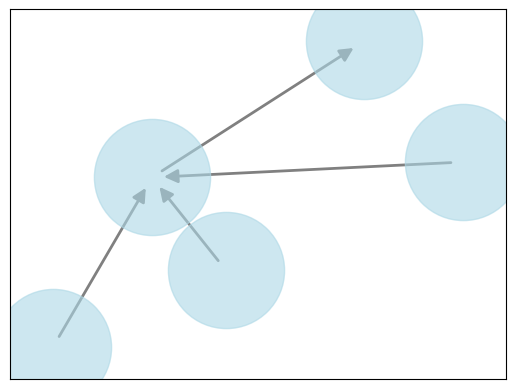

In [16]:
import matplotlib.pyplot as plt

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=7000, node_color='lightblue', alpha=0.6)

# Edges
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray', width=2)

# Node labels
node_labels = {node[0]: node[2]['name'] for node in data['nodes']}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)

# Edge labels
edge_labels = {(edge[0], edge[2]): edge[1] for edge in data['edges']}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title('Graph Visualization')
plt.axis('off')  # Turn off the axis
plt.show()  # Display the graph

In [21]:
data['nodes']

[['Oles Buzina', 'Person', {'source': 'social media', 'type': 'Person'}],
 ['Vladimir Zhirinovsky',
  'Person',
  {'source': 'social media', 'type': 'Person'}],
 ['Vladimir Solovyov', 'Person', {'source': 'social media', 'type': 'Person'}],
 ['Duel', 'Event', {'source': 'social media', 'type': 'Event'}],
 ['socio-political topics',
  'Topic',
  {'source': 'social media', 'type': 'Topic'}]]